<a href="https://colab.research.google.com/github/AedinMcCann/Thesis/blob/main/FINAL_TSLA_Rolling_Linear_submissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [17]:
pip install yfinance

In [18]:
pip install yahoofinancials

In [19]:
pip install pyfinance

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from yahoofinancials import YahooFinancials
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import pyfinance
from pyfinance import ols
import pandas_datareader as pdr
import matplotlib.pyplot as plt

# Data

In [21]:
# Get stock data
start='2020-01-01'
end='2021-01-02'
df = yf.download(tickers = "TSLA",start=start,end=end,interval = "1d")
df.reset_index(drop=False, inplace=True)

nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.tail()
df['Next_close'] = df['Close'].shift(-1)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,Next_close
248,2020-12-24,642.98999,666.090027,641.000000,661.770020,661.770020,22865600,663.690002
249,2020-12-28,674.51001,681.400024,660.799988,663.690002,663.690002,32278600,665.989990
250,2020-12-29,661.00000,669.900024,655.000000,665.989990,665.989990,22910800,694.780029
251,2020-12-30,672.00000,696.599976,668.359985,694.780029,694.780029,42846000,705.669983
252,2020-12-31,699.98999,718.719971,691.119995,705.669983,705.669983,49649900,NaN


In [22]:
# Add in some technical indicators
# Simple moving average (SMA)
# 3 day period
Close = df[['Close']]
df['SMA'] = df.Close.rolling(3, min_periods=1).mean()

# Exponential moving average (EMA)
df['EMA'] = df.Close.ewm(alpha=0.1, adjust=False).mean()

In [23]:
# On Balance Volume
# Measures cumulative buying and selling pressure by adding the volume on "up" days and subtracting volume on "down" days. 
df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
df = df.set_index('Date')
df

,Open,High,Low,Close,Adj Close,Volume,Next_close,SMA,EMA,obv
Date,,,,,,,,,,
2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,88.601997,86.052002,86.052002,0.000000e+00
2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,90.307999,87.327000,86.307001,8.889250e+07
2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,93.811996,88.320666,86.707101,1.395575e+08
2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,98.428001,90.907331,87.417591,2.289680e+08
2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,96.267998,94.182666,88.518632,3.846895e+08
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600,663.690002,649.363342,617.720086,3.423508e+09
2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600,665.989990,657.146667,622.317078,3.455786e+09
2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800,694.780029,663.816671,626.684369,3.478697e+09


In [24]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv']]

In [25]:
dataset = df.values
scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
y = dataset[:-1, 0]
x = pd.DataFrame(X)
y = pd.DataFrame(y)

In [26]:
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred = rolling.predicted
y_pred = pd.DataFrame(y_pred)
y_pred

predicted
end subperiod           
19  0           0.031208
    1           0.032532
    2           0.036133
    3           0.036744
    4           0.039522
...                  ...
251 247         0.938038
    248         0.961250
    249         0.955057
    250         0.950474
    251         0.977045

[4660 rows x 1 columns]

In [27]:
y_pred = y_pred.reset_index()
counts= y_pred['subperiod'].value_counts()
y_pred = y_pred.groupby('subperiod').sum('predicted')
y_pred['predicted'] = y_pred['predicted']/counts
y_pred = y_pred.reset_index()
y_pred

,subperiod,end,predicted
0,0,19,0.031208
1,1,39,0.030703
2,2,60,0.037699
3,3,82,0.038720
4,4,105,0.040829
...,...,...,...
247,247,1245,0.931733
248,248,998,0.949809
249,249,750,0.946957
250,250,501,0.944987


In [28]:
df_y = y.reset_index()
df_y = df_y.rename(columns={'index':'period', 0:'actual'})
df_y

,period,actual
0,0,0.025825
1,1,0.028518
2,2,0.034050
3,3,0.041337
4,4,0.037927
...,...,...
247,247,0.930694
248,248,0.933726
249,249,0.937357
250,250,0.982808


In [29]:
linear = df_y.join(y_pred, how='outer')
linear['difference'] = linear['actual'] - linear['predicted']
linear = linear.drop(['period','subperiod','end'], axis=1)
linear['sq_er'] = linear['difference']*linear['difference']
linear['TSLA_RMSE_LIN'] = np.sqrt(linear['sq_er'])
linear

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN
0,0.025825,0.031208,-0.005383,0.000029,0.005383
1,0.028518,0.030703,-0.002185,0.000005,0.002185
2,0.034050,0.037699,-0.003649,0.000013,0.003649
3,0.041337,0.038720,0.002617,0.000007,0.002617
4,0.037927,0.040829,-0.002902,0.000008,0.002902
...,...,...,...,...,...
247,0.930694,0.931733,-0.001038,0.000001,0.001038
248,0.933726,0.949809,-0.016084,0.000259,0.016084
249,0.937357,0.946957,-0.009600,0.000092,0.009600
250,0.982808,0.944987,0.037821,0.001430,0.037821


In [30]:
MSE = linear['sq_er'].sum()/len(linear)
import math 
RMSE = math.sqrt(MSE)
RMSE

0.014372575299680222

## With sentiment

In [31]:
sent = pd.read_csv('TSLA_sentiment_submissions.csv')
sent = sent.rename(columns={'date':'Date'})
sent['Date'] = pd.to_datetime(sent['Date'])
df = pd.merge(df, sent, on = 'Date', how = 'left')
#df = df.fillna(0)

df.describe()

,Next_close,Close,Volume,Open,High,Low,SMA,EMA,obv,Unnamed: 0,compound,Count,average
count,252.000000,253.000000,2.530000e+02,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02,252.000000,252.000000,252.000000,252.000000
mean,290.806373,289.997067,7.530795e+07,289.108428,297.288411,280.697937,287.564012,270.266095,1.911766e+09,182.488095,5.037606,32.817460,0.144562
std,168.839956,168.995613,4.013706e+07,167.665389,171.702889,163.350196,167.122237,154.357671,8.882851e+08,104.630006,7.139996,36.248567,0.197860
min,72.244003,72.244003,1.735770e+07,74.940002,80.972000,70.101997,81.092667,86.052002,0.000000e+00,1.000000,-4.830000,1.000000,-0.760100
25%,149.872997,149.792007,4.713450e+07,148.367996,154.990005,143.222000,149.241999,139.893243,1.329942e+09,91.750000,0.771500,11.000000,0.065281
50%,257.453995,241.731995,7.025550e+07,244.296005,245.600006,237.119995,227.206665,201.239920,1.786169e+09,183.000000,2.943150,20.000000,0.149701
75%,421.215012,421.200012,9.454550e+07,421.390015,430.500000,410.579987,421.653330,415.487761,2.803595e+09,272.250000,7.135425,39.000000,0.239371
max,705.669983,705.669983,3.046940e+08,699.989990,718.719971,691.119995,688.813334,640.711540,3.571193e+09,363.000000,46.235000,272.000000,0.980200


In [32]:
df = df[['Next_close', 'Close','Volume','Open','High','Low', "SMA", 'EMA', 'obv', 'average']]

dataset = df.values

scaler = MinMaxScaler()
# transform data
dataset = scaler.fit_transform(dataset)

X = dataset[:-1,1:]
x = pd.DataFrame(X)
rolling = ols.PandasRollingOLS(y=y, x=X, window=20)
y_pred_sent = rolling.predicted
y_pred_sent = pd.DataFrame(y_pred_sent)
y_pred_sent = y_pred_sent.reset_index()
y_pred_sent = y_pred_sent.drop(['end'], axis=1)
y_pred_sent

,subperiod,predicted
0,0,0.030107
1,1,0.033344
2,2,0.036622
3,3,0.036641
4,4,0.039589
...,...,...
4655,247,0.920814
4656,248,0.944290
4657,249,0.972901
4658,250,0.955665


In [33]:
y_pred_sent = y_pred_sent.reset_index()
counts= y_pred_sent['subperiod'].value_counts()
y_pred_sent = y_pred_sent.groupby('subperiod').sum('predicted')
y_pred_sent['predicted_sent'] = y_pred_sent['predicted']/counts

In [34]:
linear_sent = df_y.join(y_pred_sent, how='outer')
linear_sent = linear_sent.rename(columns = {0:'actual'})
linear_sent

,period,actual,index,predicted,predicted_sent
0,0,0.025825,0,0.030107,0.030107
1,1,0.028518,21,0.060856,0.030428
2,2,0.034050,63,0.113278,0.037759
3,3,0.041337,126,0.155579,0.038895
4,4,0.037927,210,0.207595,0.041519
...,...,...,...,...,...
247,247,0.930694,23085,4.600477,0.920095
248,248,0.933726,18510,3.754082,0.938520
249,249,0.937357,13914,2.884556,0.961519
250,250,0.982808,9297,1.898182,0.949091


In [35]:
linear_sent['difference_sent'] = linear_sent['actual'] - linear_sent['predicted_sent']
linear_sent = linear_sent.drop(['predicted'], axis=1)
linear_sent['sq_er_sent'] = linear_sent['difference_sent']*linear_sent['difference_sent']
linear_sent['TSLA_RMSE_LIN_SENTIMENT'] = np.sqrt(linear_sent['sq_er_sent'])
linear_sent

,period,actual,index,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
0,0,0.025825,0,0.030107,-0.004283,0.000018,0.004283
1,1,0.028518,21,0.030428,-0.001910,0.000004,0.001910
2,2,0.034050,63,0.037759,-0.003710,0.000014,0.003710
3,3,0.041337,126,0.038895,0.002442,0.000006,0.002442
4,4,0.037927,210,0.041519,-0.003592,0.000013,0.003592
...,...,...,...,...,...,...,...
247,247,0.930694,23085,0.920095,0.010599,0.000112,0.010599
248,248,0.933726,18510,0.938520,-0.004795,0.000023,0.004795
249,249,0.937357,13914,0.961519,-0.024162,0.000584,0.024162
250,250,0.982808,9297,0.949091,0.033717,0.001137,0.033717


In [36]:
MSE_sent = linear_sent['sq_er_sent'].sum()/len(linear_sent)
RMSE_sent = math.sqrt(MSE_sent)
RMSE_sent

0.042306778759116696

In [37]:
TSLA_linear = pd.merge(linear, linear_sent, on = 'actual')
TSLA_linear

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
0,0.025825,0.031208,-0.005383,0.000029,0.005383,0,0,0.030107,-0.004283,0.000018,0.004283
1,0.028518,0.030703,-0.002185,0.000005,0.002185,1,21,0.030428,-0.001910,0.000004,0.001910
2,0.034050,0.037699,-0.003649,0.000013,0.003649,2,63,0.037759,-0.003710,0.000014,0.003710
3,0.041337,0.038720,0.002617,0.000007,0.002617,3,126,0.038895,0.002442,0.000006,0.002442
4,0.037927,0.040829,-0.002902,0.000008,0.002902,4,210,0.041519,-0.003592,0.000013,0.003592
...,...,...,...,...,...,...,...,...,...,...,...
247,0.930694,0.931733,-0.001038,0.000001,0.001038,247,23085,0.920095,0.010599,0.000112,0.010599
248,0.933726,0.949809,-0.016084,0.000259,0.016084,248,18510,0.938520,-0.004795,0.000023,0.004795
249,0.937357,0.946957,-0.009600,0.000092,0.009600,249,13914,0.961519,-0.024162,0.000584,0.024162
250,0.982808,0.944987,0.037821,0.001430,0.037821,250,9297,0.949091,0.033717,0.001137,0.033717


In [38]:
TSLA_linear.describe()

,actual,predicted,difference,sq_er,TSLA_RMSE_LIN,period,index,predicted_sent,difference_sent,sq_er_sent,TSLA_RMSE_LIN_SENTIMENT
count,252.000000,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000
mean,0.345048,0.344901,0.000147,2.065709e-04,0.009885,125.500000,43077.261905,0.331169,0.013879,1.789864e-03,0.022359
std,0.266550,0.265516,0.014400,5.170347e-04,0.010454,72.890329,26629.505398,0.276794,0.040045,5.338324e-03,0.035987
min,0.000000,0.007305,-0.060117,3.900776e-09,0.000062,0.000000,0.000000,0.000000,-0.058645,7.435536e-09,0.000086
25%,0.122554,0.123948,-0.006597,7.595345e-06,0.002756,62.750000,19890.000000,0.083767,-0.005012,1.414681e-05,0.003761
50%,0.292394,0.278559,-0.000736,5.107268e-05,0.007145,125.500000,42990.000000,0.270207,0.002183,9.790016e-05,0.009894
75%,0.550926,0.550672,0.007428,1.745104e-04,0.013210,188.250000,66090.000000,0.549753,0.014010,4.204370e-04,0.020504
max,1.000000,0.977045,0.072084,5.196116e-03,0.072084,251.000000,89190.000000,0.977495,0.181255,3.285343e-02,0.181255


Text(0.5, 0.98, 'Root Mean Squared Error Distribution With Sentiment')

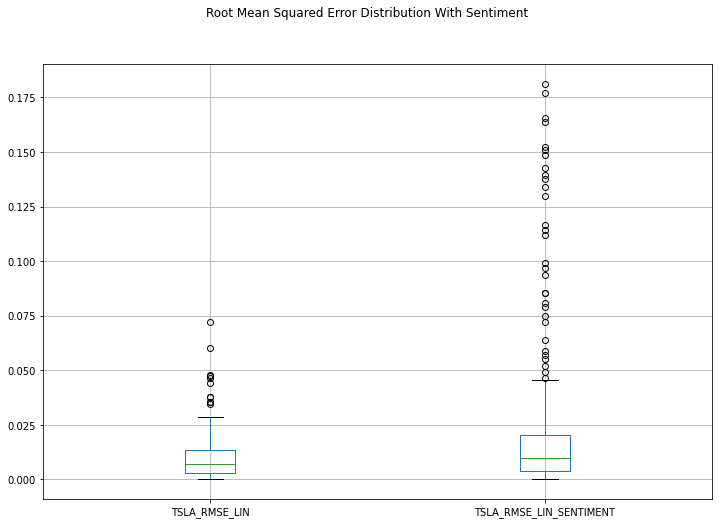

In [39]:
boxplot = TSLA_linear.boxplot(column=['TSLA_RMSE_LIN', 'TSLA_RMSE_LIN_SENTIMENT'],figsize=(12,8))
[ax_tmp.set_xlabel('') for ax_tmp in np.asarray(boxplot).reshape(-1)]
fig = np.asarray(boxplot).reshape(-1)[0].get_figure()
fig.suptitle('Root Mean Squared Error Distribution With Sentiment')

In [40]:
TSLA_linear_RMSE = TSLA_linear[['TSLA_RMSE_LIN', 'TSLA_RMSE_LIN_SENTIMENT']]
TSLA_linear_RMSE.describe()

,TSLA_RMSE_LIN,TSLA_RMSE_LIN_SENTIMENT
count,252.000000,252.000000
mean,0.009885,0.022359
std,0.010454,0.035987
min,0.000062,0.000086
25%,0.002756,0.003761
50%,0.007145,0.009894
75%,0.013210,0.020504
max,0.072084,0.181255


In [41]:
TSLA_linear_RMSE.to_csv('TSLA_Linear_Subs_Results.csv')